<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/xPass_%2B_xDEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Specify the path to `BM2425.xlsx` in Google Drive
file_path = '/content/drive/My Drive/BM2425.xlsx'

# Step 3: Load the file directly from Google Drive
data = pd.read_excel(file_path, usecols=['playerName', 'contestantId', 'x', 'y', 'endX', 'endY', 'outcome', 'typeId'], nrows=1000)

# Step 4: Filter for passes (e.g., typeId == 1) and defensive actions (e.g., typeId == 7 or 8)
passes = data[data['typeId'] == 1]  # Assuming typeId == 1 indicates passes
defensive_actions = data[data['typeId'].isin([7, 8])]  # Assuming typeId == 7, 8 are defensive actions

# Identify receivers based on outcome == 1 and next action by a different player
passes['receiverName'] = None
for idx, pass_row in passes.iterrows():
    if pass_row['outcome'] == 1:
        subsequent_actions = data[(data['x'] == pass_row['endX']) & (data['y'] == pass_row['endY']) & (data['playerName'] != pass_row['playerName'])]
        if not subsequent_actions.empty:
            passes.at[idx, 'receiverName'] = subsequent_actions.iloc[0]['playerName']

# Add Pressure successful column
passes['Pressure successful'] = passes['receiverName'].apply(lambda x: 'no' if pd.notna(x) else 'yes')

# Define a threshold for distance calculations
threshold = 10  # Define a threshold in meters

# Function to calculate distance weight
def calculate_distance_weight(distance, max_distance=threshold):
    return max(0, 1 - distance / max_distance)  # Weight decreases linearly with distance

matched_actions = []

for _, pass_row in passes.iterrows():
    for _, def_row in defensive_actions.iterrows():
        # Ensure defender belongs to a different contestantId
        if pass_row['contestantId'] != def_row['contestantId']:
            # Check spatial proximity
            distance = np.sqrt((pass_row['endX'] - def_row['x']) ** 2 + (pass_row['endY'] - def_row['y']) ** 2)
            if distance <= threshold:
                # Calculate metrics
                pre_action_danger = 1 - (
                    0.02 * distance +
                    0.1 * np.abs(np.arctan2(pass_row['endY'] - pass_row['y'], pass_row['endX'] - pass_row['x']))
                )
                pre_action_danger = max(0, min(1, pre_action_danger))  # Clip between 0 and 1
                post_action_danger = pre_action_danger * (0.5 if def_row['outcome'] == 1 else 1.0)

                # Calculate distance weight
                distance_weight = calculate_distance_weight(distance)

                # Adjust xDef with distance weight
                xDef = (pre_action_danger - post_action_danger) * distance_weight

                # Calculate xPass for the pass
                xPass = 1 - (
                    0.02 * distance +
                    0.1 * np.abs(np.arctan2(pass_row['endY'] - pass_row['y'], pass_row['endX'] - pass_row['x']))
                )
                xPass = max(0, min(1, xPass))  # Clip xPass to be between 0 and 1

                matched_actions.append({
                    'passer': pass_row['playerName'],
                    'receiver': pass_row['receiverName'],
                    'Pressure successful': pass_row['Pressure successful'],
                    'defender': def_row['playerName'],
                    'xPass': xPass,
                    'pre_action_danger': pre_action_danger,
                    'post_action_danger': post_action_danger,
                    'xDef': xDef,
                    'distance_weight': distance_weight,
                    'pass_start': (pass_row['x'], pass_row['y']),
                    'pass_end': (pass_row['endX'], pass_row['endY']),
                    'defensive_action': (def_row['x'], def_row['y']),
                    'distance': distance
                })

# Step 6: Save results to a DataFrame
matched_df = pd.DataFrame(matched_actions)

# Step 7: Save results directly to Google Drive
output_filename = '/content/drive/My Drive/Matched_Passes_With_Defensive_Actions_Threshold_10_Meters.xlsx'
matched_df.to_excel(output_filename, index=False)

print(f"Results saved directly to Google Drive at '{output_filename}'")

# Optional: Print a preview of the results
print("Preview of Matched Actions:")
print(matched_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-4-f35eae96ebc5>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes['receiverName'] = None
<ipython-input-4-f35eae96ebc5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes['Pressure successful'] = passes['receiverName'].apply(lambda x: 'no' if pd.notna(x) else 'yes')


Results saved directly to Google Drive at '/content/drive/My Drive/Matched_Passes_With_Defensive_Actions_Threshold_10_Meters.xlsx'
Preview of Matched Actions:
         passer   receiver Pressure successful     defender     xPass  \
0   A. Pavlović  A. Davies                  no  J. Kamiński  0.706677   
1   A. Pavlović  A. Davies                  no  J. Kamiński  0.643398   
2  D. Upamecano       None                 yes    P. Wimmer  0.624709   
3  D. Upamecano       None                 yes    P. Wimmer  0.605798   
4      M. Neuer       None                 yes  Tiago Tomás  0.676873   

   pre_action_danger  post_action_danger      xDef  distance_weight  \
0           0.706677            0.353338  0.150422         0.425718   
1           0.643398            0.321699  0.035170         0.109326   
2           0.624709            0.312354  0.050125         0.160476   
3           0.605798            0.302899  0.019968         0.065923   
4           0.676873            0.338436  0.017

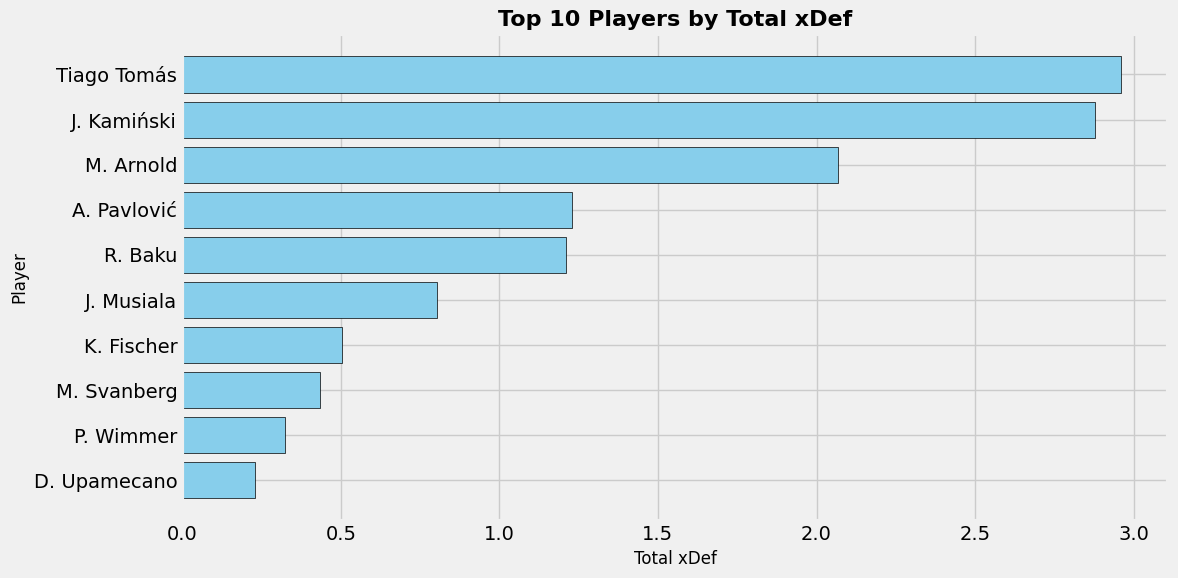

        defender  total_xDef
0    A. Pavlović    1.229281
1   D. Upamecano    0.229221
2    J. Kamiński    2.877534
3     J. Kimmich    0.000000
4     J. Musiala    0.804639
5     K. Fischer    0.504400
6      M. Arnold    2.068648
7    M. Svanberg    0.435570
8      P. Wimmer    0.323687
9        R. Baku    1.211567
10       S. Boey    0.000000
11   Tiago Tomás    2.960116


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style

# Example: Load your matched_df DataFrame here
# matched_df = pd.read_excel("Matched_Passes_Defensive_Actions_With_Weights.xlsx")

# Summarize total xDef for each player
player_summary = matched_df.groupby('defender').agg(
    total_xDef=('xDef', 'sum')
).reset_index()

# Get the top players with the highest total xDef
top_xDef_players = player_summary.nlargest(10, 'total_xDef')

# Enable fivethirtyeight style for the plot
style.use('fivethirtyeight')

# Create a horizontal bar graph for the top players by xDef
plt.figure(figsize=(12, 6))
plt.barh(top_xDef_players['defender'], top_xDef_players['total_xDef'], color='skyblue', edgecolor='black')
plt.title('Top 10 Players by Total xDef', fontsize=16, weight='bold')
plt.xlabel('Total xDef', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.gca().invert_yaxis()  # Highest value at the top
plt.tight_layout()
plt.show()

# Print the summarized data for verification
print(player_summary)
